In [727]:
import cirq
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1981.94it/s]


{0: [(0.16592785032250768+0j) [Z1 Z2]],
 1: [(0.12062523481381837+0j) [Z1 Z3]],
 2: [(0.16592785032250768+0j) [Z0 Z3]],
 3: [(0.1686889816869329+0j) [Z0 Z1]],
 4: [(-0.09706626861762624+0j) []],
 5: [(0.174412876106516+0j) [Z2 Z3]],
 6: [(0.12062523481381837+0j) [Z0 Z2]],
 7: [(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]],
 8: [(-0.2234315367466397+0j) [Z3], (0.04530261550868928+0j) [Y0 X1 X2 Y3]],
 9: [(-0.2234315367466397+0j) [Z2], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]],
 10: [(0.04530261550868928+0j) [X0 Y1 Y2 X3], (0.171412826394024+0j) [Z1]]}

In [728]:
from quchem.Unitary_partitioning import *

The Hamiltonian is a sum of $m$ PauliWords:

$$H=\sum_{j=0}^{m-1} \alpha_{j} P_{j}$$

In this there are $l$ completely anti-commuting sets, denoted as $H_{S_{l}}$:


$$H =\sum_{l} H_{S_{l}}$$

where each anti-commuting set is defined as:

$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}$$

where:
- $\left\{P_{j}, P_{k}\right\}=0$ for $\forall P_{j} \neq P_{k} \in S_{l}$


We want **want** the sum of the squares of the cofactors to be 1:

$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S_{l}} \beta_{j} P_{j}$$

- aka: $\sum_{j} \beta_{j}^{2}=1$
- and $\gamma_{l}$ is the correction factor: $\alpha_{j} =  \gamma_{l} \beta_{j}$

SO overall we can turn our Hamiltonian into $l$ anti_commutings sets as:

$$H=\sum_{l} H_{S_{l}} = \sum_{l} \sum_{\substack{j=0 \\  P_{j} \in S_{l}}}^{|S_{l}|-1} \alpha_{j} P_{j}= \sum_{l} \gamma_{l} \sum_{\substack{j=0 \\  P_{j} \in S_{l}}}^{|S_{l}|-1} \beta_{j} P_{j}$$

## STEP 1:

**Get normalised anti_commuting sets**

$$H_{S_{l}}=\sum_{P_{j} \in S_{l}} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S_{l}} \beta_{j} P_{j}$$

In [729]:
# achieved using Get_beta_j_cofactors function
Get_beta_j_cofactors(anti_commuting_sets[7])

{'PauliWords': [(0.9668047296891765+0j) [Z0],
  (-0.25551636865500044+0j) [X0 X1 Y2 Y3]],
 'gamma_l': (0.17729829109248618+0j)}

## STEP 2:

we can define an operator:

$$\mathcal{X}_{s k}=i P_{s} P_{k}$$

$$R_{s k}=\exp \left(-i \frac{\theta_{s k}}{2} \mathcal{X}_{s k}\right)$$

$R$ operates as follows:

- $R_{s k} P_{k} R_{s k}^{\dagger}=\cos \theta_{s k} P_{k}+\sin \theta_{s k} P_{s}$
- $R_{s k} P_{s} R_{s k}^{\dagger}=-\sin \theta_{s k} P_{k}+\cos \theta_{s k} P_{s}$

Therefore when acting on $\frac{H_{S_{l}}}{\gamma_{l}} (= \sum_{P_{j} \in S_{l}} \beta_{j} P_{j})$

$$\begin{aligned} R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}=&\left(\beta_{k} \cos \theta_{s k}-\beta_{s} \sin \theta_{s k}\right) P_{k} \\ &+\left(\beta_{k} \sin \theta_{s k}+\beta_{s} \cos \theta_{s k}\right) P_{s} \\ &+\sum_{\substack{j\neq k \\ j\neq s \\  P_{j} \in S_{l}}} \beta_{j} P_{j} \end{aligned}$$

NOW by setting

$$\beta_{k} \cos \theta_{s k}=\beta_{s} \sin \theta_{s k}$$


The $P_{k}$ term in $R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}$ goes to **zero**

BUT NOTICE

The amplitude of the $P_{s}$ term in $R_{s k} \bigg( \frac{H_{S_{l}}}{\gamma_{l}} \bigg) R_{s k}^{\dagger}$ **increases** by $\beta_{k} \sin \theta_{s k}+\beta_{s} \cos \theta_{s k} (= 2 \times \beta_{s} \cos \theta_{s k} = 2 \times \beta_{k} \sin \theta_{s k})$


$$\frac{\sin \theta_{s k}}{\cos \theta_{s k}} = \frac{\beta_{k}}{\beta_{s}}$$
$$\tan \theta_{s k} = \frac{\beta_{k}}{\beta_{s}}$$
$$\theta_{s k} = \tan^{-1} \big(\frac{\beta_{k}}{\beta_{s}} \big)$$

In [733]:
diction = Get_beta_j_cofactors(anti_commuting_sets[7])
Get_X_sk_operators(diction, S=1)

## PROBLEM ^^ the .terms.items() <-- seems to jumble pauliwords and so indexing of S becomes a problem!

{'X_sk_and_theta_terms': [{'X_sk': (1+0j) [Y0 X1 Y2 Y3],
   'theta_sk_over2': (0.9145890452628486+0j)}],
 'PauliWord_S': 1 [X0 X1 Y2 Y3],
 'gamma_l': (0.17729829109248618+0j)}

In [737]:
# Andrew's code to get theta_sk
def thetasFromOplist(normalisedOplist):
    betas = [x for x in normalisedOplist]
    squaredBetas = [x**2 for x in betas]

    runningTotal = squaredBetas[-1]
    squaredBetaSums = [runningTotal]
    for i in range(1,len(normalisedOplist)-1):
        runningTotal += squaredBetas[i-1]
        squaredBetaSums.append(runningTotal)

    l2Betas = [x**(1./2.) for x in squaredBetaSums]
    l2Betas[0] = betas[-1]
    thetas = [np.arctan(betas[i]/l2Betas[i]) for i in range(len(l2Betas))]
    if betas[-1].real < 0.:
        thetas[0] = thetas[0] + np.pi
    return thetas

thetasFromOplist([0.9668047296891765, -0.25551636865500044])
# thetasFromOplist([-0.25551636865500044,0.9668047296891765])

[1.8291780905256971]

In [738]:
testing = {'PauliWords': [QubitOperator('Z0',0.5),QubitOperator('X0',0.5),
                QubitOperator('Z1',0.5), QubitOperator('Y1',0.5)],
         'gamma_l': 1}
Get_X_sk_operators(testing, S=0)

{'X_sk_and_theta_terms': [{'X_sk': (-1+0j) [Y0],
   'theta_sk_over2': 0.39269908169872414},
  {'X_sk': (-1+0j) [Y0], 'theta_sk_over2': 0.30773985433519363},
  {'X_sk': (-1+0j) [Y0], 'theta_sk_over2': 0.26179938779914946}],
 'PauliWord_S': 1 [Z0],
 'gamma_l': 1}

In [740]:
thetasFromOplist([0.5,0.5,0.5,0.5]) #note P_s is last term!
#should be double theta_sk_over2 terms above!!

[0.7853981633974483, 0.6154797086703873, 0.5235987755982989]

## Step 3

$$U=e^{-i \theta Z_{0} Z_{1} Z_{2} Z_{3}} ==> R_z(2\theta)$$

SO:

$$R_{s k}=\exp \left(-i \frac{\theta_{s k}}{2} \mathcal{X}_{s k}\right) == R_z(\theta_{s k})$$

In [742]:
diction = Get_beta_j_cofactors(anti_commuting_sets[8])
X_sk_dict = Get_X_sk_operators(diction, S=0)

print(X_sk_dict)
print('')

pp = Build_reduction_circuit(X_sk_dict)
print(cirq.Circuit(pp))

{'X_sk_and_theta_terms': [{'X_sk': (1+0j) [Y0 X1 X2 X3], 'theta_sk_over2': (1.4707731108182085+0j)}], 'PauliWord_S': 1 [Z3], 'gamma_l': (0.22797802215321797+0j)}

0: ───Rx(0.5π)───@──────────────────────────────────────────────────@───Rx(-0.5π)───
                 │                                                  │
1: ───H──────────X───@──────────────────────────────────────────@───X───H───────────
                     │                                          │
2: ───H──────────────X───@──────────────────────────────────@───X───H───────────────
                         │                                  │
3: ───H──────────────────X───Rz((0.9363232430134475+0j)π)───X───H───────────────────


$$R_{S} H_{S} R_{S}^{\dagger}=P_{s}$$

aka we want: $$H_{S}=  R_{S}^{\dagger} P_{s} R_{S}$$

to get this via a quantum circuit we do $R_{S}$... THEN measure $P_{s}$:

$$M_{z} U_{s} R_{S} |\psi_{UCCSD}\rangle == \langle \psi_{UCCSD}|R_{S}^{\dagger} P_{s} R_{S}|\psi_{UCCSD}\rangle$$ 

- $U_{s}$ is change of basis to measure  $P_{s}$ in comp basis!
- $M_{z}$ is measurement in Z



In [743]:
# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [744]:
diction = Get_beta_j_cofactors(anti_commuting_sets[8])
X_sk_dict = Get_X_sk_operators(diction, S=0)

print(X_sk_dict['PauliWord_S'])

Generate_Full_Q_Circuit_unitary_part(ansatz_cirq_circuit,X_sk_dict)

1 [Z3]


0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────────────────────────@───Rx(-0.5π)───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │                          │                                                  │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───H──────────X───@──────────────────────────────────────────@───X───H───────────
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │                                          │                                          │
2: ───H──────────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───H──────────────────────────X───@──────────────────────────────────@───X───H───────────────
                   

In [745]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)


# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,transformation='JW')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)


n_shots=1000
experiment = VQE_Experiment_UP(anti_commuting_sets, ansatz_cirq_circuit, n_shots, S_key_dict=None)#{7:1, 8:1, 9:0, 10:0})
experiment.Calc_Energy()

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 978.16it/s]


-1.1170556366100683

In [746]:
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, ansatz_cirq_circuit, n_shots, S_key_dict=None)#{7:1, 8:1, 9:0, 10:0})
    
    return VQE_exp_UP.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[0,1,2]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

0: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1198927323380283
1: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.117663470312317
2: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.113256433668155
3: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1170047953437674
4: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1170556366100683
5: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1163972847119994
6: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1172583555343112
7: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.116802722560485
8: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1147253381927156
9: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.06666667e+00]: Output: -1.1135096707882186
10: Input_to_Funct: [1.66666667e-04 9.50000000e-01 2.

KeyboardInterrupt: 

# REDUCED H2 ANSATZ

$$U_{UCCSD}^{H2}=e^{-i \theta Y_{0} X_{1} X_{2} X_{3}}$$

In [747]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)    

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [748]:
n_shots=10000

def GIVE_ENERGY(THETA):
    H2_ansatz_cirq_circuit = H2_ansatz(THETA)
    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, H2_ansatz_cirq_circuit, n_shots,
                                   S_key_dict={7:0, 8:0, 9:0, 10:1})#None)
    
    return VQE_exp_UP.Calc_Energy()


In [726]:
GIVE_ENERGY(np.pi) 

-1.1176991238128235

-1.1370913127149602
-1.13728383451232


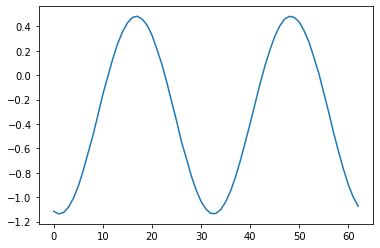

In [750]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))
print(Hamilt.molecule.ccsd_energy)

0: Input_to_Funct: [0.9]: Output: -0.3343539003577825
1: Input_to_Funct: [0.7]: Output: -0.6387726923757656
2: Input_to_Funct: [0.3]: Output: -1.0801191790272018
3: Input_to_Funct: [0.1]: Output: -1.1370913127149602
4: Input_to_Funct: [0.1]: Output: -1.1372686110060526
5: Input_to_Funct: [0.1]: Output: -1.1370203933985232
6: Input_to_Funct: [0.125]: Output: -1.1369848691262086
7: Input_to_Funct: [0.1125]: Output: -1.1371926075629857
8: Input_to_Funct: [0.11875]: Output: -1.1373344461958597
9: Input_to_Funct: [0.11875]: Output: -1.1374053655122967
10: Input_to_Funct: [0.11875]: Output: -1.137222983094574
11: Input_to_Funct: [0.11875]: Output: -1.1372432549869982
12: Input_to_Funct: [0.11875]: Output: -1.1370811444617
13: Input_to_Funct: [0.11875]: Output: -1.137141927831925
14: Input_to_Funct: [0.11875]: Output: -1.137233119040786
15: Input_to_Funct: [0.11875]: Output: -1.1373952295660845
16: Input_to_Funct: [0.11875]: Output: -1.1372685786990047
17: Input_to_Funct: [0.11875]: Output: -

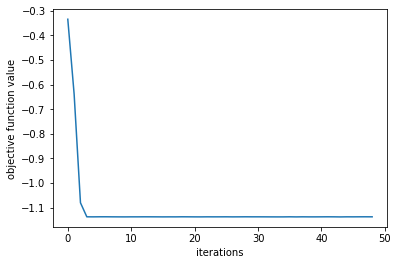

In [751]:
### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[1]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()